<a href="https://colab.research.google.com/github/satani99/fastai_22_2/blob/main/DDPM_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/fastai/course22p2.git
%cd course22p2

Cloning into 'course22p2'...
remote: Enumerating objects: 1176, done.
remote: Counting objects: 100% (1176/1176), done.
remote: Compressing objects: 100% (480/480), done.
remote: Total 1176 (delta 712), reused 1117 (delta 694), pack-reused 0
Receiving objects: 100% (1176/1176), 99.81 MiB | 25.47 MiB/s, done.
Resolving deltas: 100% (712/712), done.
/content/course22p2


In [2]:
!pip install datasets
!pip install torcheval
!pip install diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.6 MB/s eta 0:00:00


In [3]:
import pickle,gzip,math,os,time,shutil,torch,random,logging
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [4]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

In [5]:
xl, yl = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
dt = dls.train
xb, yb = next(iter(dt))

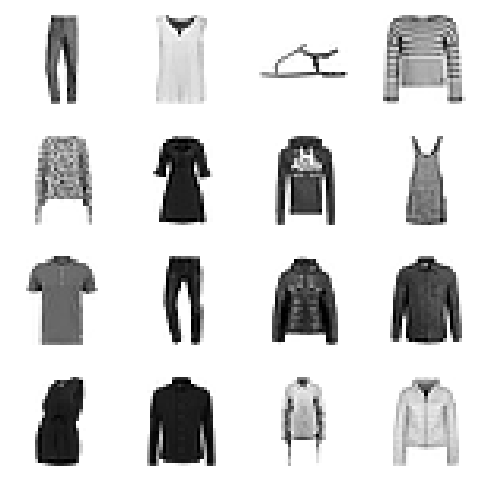

In [7]:
show_images(xb[:16], imsize=1.5)

In [8]:
betamin, betamax, n_steps = 0.0001, 0.02, 1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1.-beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

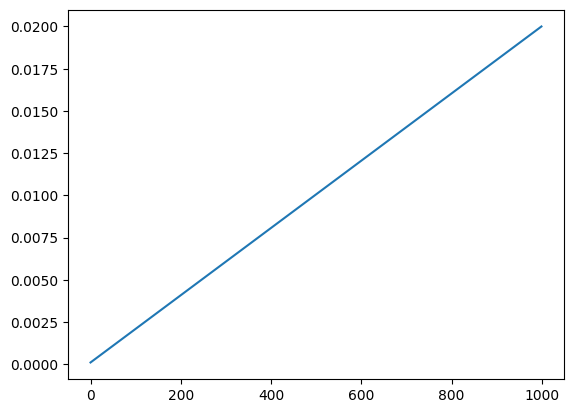

In [9]:
plt.plot(beta);

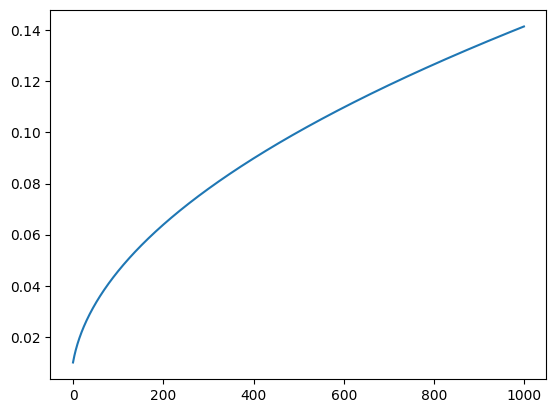

In [10]:
plt.plot(sigma);

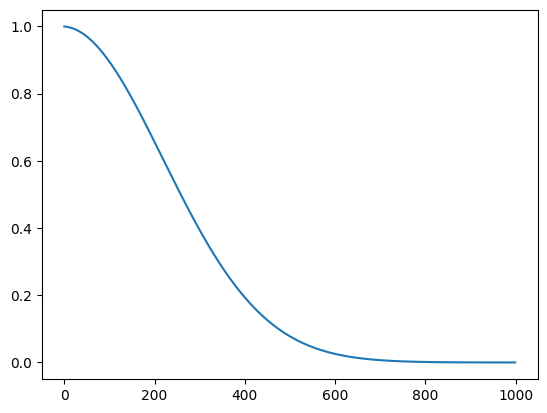

In [11]:
plt.plot(alphabar);

In [12]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε


In [13]:
(xt,t),ε = noisify(xb[:25],alphabar)
t


tensor([877, 417, 471, 594, 883, 906, 753, 344, 183, 427, 804,  84, 853, 789,
        985, 442, 222,  28, 418, 913, 562, 768, 154, 341, 830])

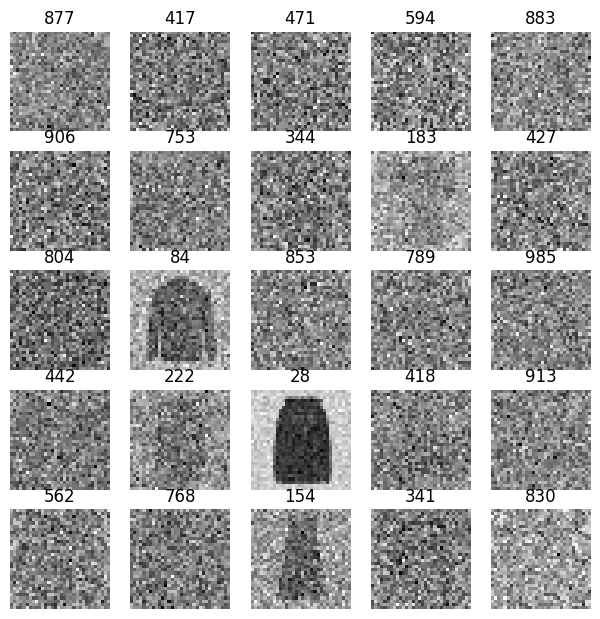

In [14]:
titles = fc.map_ex(t, '{}')
show_images(xt, imsize=1.5, titles=titles)

In [21]:
from diffusers import UNet2DModel

In [17]:
@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
  device = next(model.parameters()).device
  x_t = torch.randn(sz, device=device)
  preds = []
  for t in reversed(range(n_steps)):
    t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
    z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
    ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
    b̄_t = 1 - alphabar[t]
    b̄_t1 = 1 - ᾱ_t1
    x_0_hat = ((x_t - b̄_t.sqrt() * learn.model((x_t, t_batch)))/alphabar[t].sqrt()).clamp(-1,1)
    x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
    preds.append(x_t.cpu())
  return preds

In [18]:
class DDPMCB(Callback):
  order = DeviceCB.order + 1
  def __init__(self, n_steps, beta_min, beta_max):
    super().__init__()
    fc.store_attr()
    self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
    self.α = 1. - self.beta
    self.ᾱ = torch.cumprod(self.α, dim=0)
    self.σ = self.beta.sqrt()

  def before_batch(self, learn): learn.batch = noisify(learn.batch[0], self.ᾱ)
  def sample(self, model, sz): return sample(model, sz, self.α, self.ᾱ, self.σ, self.n_steps)

In [22]:
class UNet(UNet2DModel):
  def forward(self, x): return super().forward(*x).sample

In [23]:
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


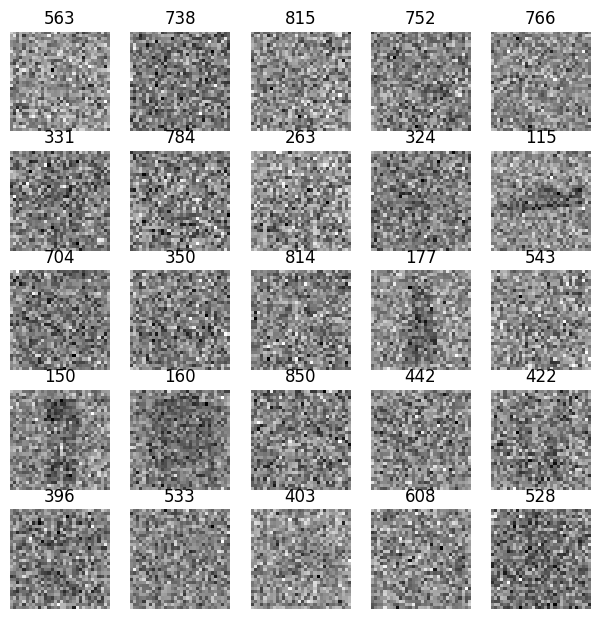

In [24]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16,32,64,64), norm_num_groups=8)

learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs=[ddpm_cb,SingleBatchCB()])
(xt,t),ε = learn.batch
show_images(xt[:25], titles=fc.map_ex(t[:25], '{}'), imsize=1.5)

In [25]:
lr = 5e-3
epochs = 5

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

In [26]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16,32,64,128), norm_num_groups=8)

In [27]:
def init_ddpm(model):
  for o in model.down_blocks:
    for p in o.resnets:
      p.conv2.weight.data.zero_()
      for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

  for o in model.up_blocks:
    for p in o.resnets: p.conv2.weight.data.zero_()

  model.conv_out.weight.data.zero_()

In [28]:
init_ddpm(model)

In [29]:
opt_func = partial(optim.Adam, eps=1e-5)

In [30]:
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.148,0,train
0.028,0,eval
0.023,1,train
0.022,1,eval
0.020,2,train
0.020,2,eval
0.019,3,train
0.018,3,eval
0.018,4,train
0.018,4,eval


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


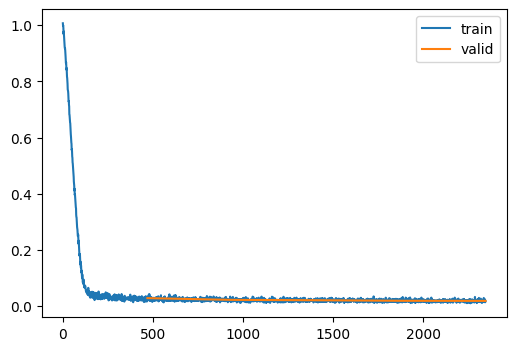

In [31]:
learn.fit(epochs)